In [75]:
from pydantic import BaseModel
from typing_extensions import TypedDict, Annotated
from operator import add

from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END

llm = init_chat_model("openai:gpt-4o")

In [76]:
with open("README.md", "r", encoding="utf-8") as file:
    readme = file.read()

In [77]:

import random
import time


class State(TypedDict):
    doc: str
    final_summary: str
    chunkedList: Annotated[list[dict], add]


class ChunkedOutput(BaseModel):
    index: int
    chunck: str


class ChunkListOutput(BaseModel):
    chunks: list[ChunkedOutput]


from langgraph.types import Send


def chunk_ai(state: State):
    doc = state.get("doc", "")
    output_structured_llm = llm.with_structured_output(ChunkListOutput)

    chunked_res = output_structured_llm.invoke(
        f"""
        문서를 읽고 적당한 의미 단위로 나눈 뒤 각각의 내용을 한국어로 다시 한번 정리하고 재구성해줘.

        <doc>
        문서:{doc}
        </doc>
        """
    )

    return [Send("make_example", chunk) for chunk in chunked_res.chunks]


def make_example(arg: ChunkedOutput):
    index = arg.index
    chunk = arg.chunck

    inte = random.randint(0, 2) * random.randint(1, 3)
    print(f"✅✅{index}✅{inte}✅✅")
    time.sleep(inte)

    ex_res = llm.invoke(
        f"""
        아래 제시되는 문장을 읽고 떠오르는 한국의 명언이나 속담 또는 절절한 문장을 생성해줘. 길이는 대략 40글자 내외로

        <doc>
        문장 : {chunk}
        </doc>
        """
    )
    print(f"⌛⌛{index}⌛{inte}⌛⌛")
    return {
        "chunkedList": [{"index": index, "chunk": chunk, "example": ex_res.content}],
    }


def final_content(state: State):
    unsorted_chunked_list = state.get("chunkedList", [])
    sorted_chunked_list = sorted(unsorted_chunked_list, key=lambda x: x["index"], reverse=False)

    final_res = llm.invoke(
        f"""
        아래의 데이터를 읽고 800자 분량의 요약본을 만들어줘

        <data>
        데이터 : {sorted_chunked_list}
        </data>
        """
    )

    return {
        "final_summary": final_res.content,
    }


In [78]:
graph_builder = StateGraph(State)

(
    graph_builder

    .add_node("make_example", make_example)
    .add_node("final_content", final_content)

    .add_conditional_edges(START, chunk_ai, ["make_example"])
    .add_edge("make_example", "final_content")
    .add_edge("final_content", END)
)

graph = graph_builder.compile()

graph.invoke({
    "doc": readme
})

✅✅1✅1✅✅
✅✅2✅0✅✅
✅✅3✅1✅✅
✅✅4✅3✅✅
✅✅5✅0✅✅
⌛⌛5⌛0⌛⌛
⌛⌛2⌛0⌛⌛
⌛⌛1⌛1⌛⌛
⌛⌛3⌛1⌛⌛
⌛⌛4⌛3⌛⌛


{'doc': "'네, 안녕하세요. 오늘은, 오늘 책도, 오늘 아침에 읽은 책도, 여기 보이시죠? 넥서스입니다, 넥서스. 오늘도 제가 아침에 책을 읽었고요. 이렇게 1차적으로는 수첩에다가 이렇게 적습니다. 1차적으로 좋은 문장들을\n적고, 이렇게 문장들을 적은 다음에 적고, 제가 챕터별로 딱 3개의 문장만 뽑아서 살짝 제 스타일대로 요약을 합니다. 요약을 하고 나서 질문 하나씩 적고, 답변을 다는 방식으로 이렇게 준비를 하고 있습니다. 지금\n이틀 정도 해봤는데, 상당히 좋은 것 같아요. 책의 내용도 많이 기억에 남고, 요약을 하다보니까 더 많은 생각을 할 수 있게 되고, 그런 것 같습니다. 그래서 일단 잠깐 보시면은, 짜잔, 넥서스죠? 저번 1편에서도\n보여드리긴 했는데, 이번 하루의 책이고요. 오늘은 목차를 보면은, 저번 영상에서는 프로로그를 담았고, 이번에는 정보란 무엇인가, 정보가 뭔지, 그리고 이야기, 이야기에 대한 두 장을 제가 요약을 했고요. 보시면은,\n정보란 무엇인가, 여기서 인상 깊었던 구절을 제가 조금 변형해서 적어봤습니다. 책 이름이 넥서스인데, 궁극적으로는 각 개인은 서로 다른 세계관을 가지며, 그것은 그 사람의 성격과 인생사가 교차하면 형성된다. 정보란\n무엇인가잖아요? 정보는 사회적 연결고리, 넥서스라는 거죠. 그러니까 종이랑 종이랑 붙이는 풀처럼 사람들을 연결해주는 그런 사회적 연결고리가 넥서스고, 그것도 정보를 정의한다고 얘기를 하는 것 같습니다. 사람들은 정말\n서로 다른 세계관을 가지죠. 그래서 여러분들의 세계관은, 그 세계관에서는 무엇이 가치 있다고 생각하시는지, 그걸 한번 생각해보시면 좋을 것 같아요. 네, 두 번째입니다. 이 문장도 참 좋았는데요. 과학적이나 정치\n연설 같은 몇 가지 유형의 정보는, 사람들에게 현실을 정확하게 표현해서 사람들을 하나로 묶으려고 하죠. 그런데 사람들을 묶는데 효과적인 정보는 이런 사실이 아니고, 허구인 매력적인 정보가 오히려 사람들에게 잘\n퍼지고, 사람들을 잘 묶는다는 얘기죠. 그래서 좋

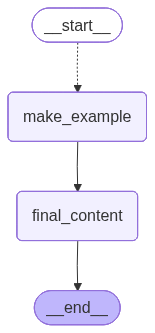

In [79]:
display(graph)